In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from multicopy_STR_genotyping import file_io, str_utils

sns.set_context("poster")
%matplotlib inline

In [2]:
# def dfs_from_vcf(file: str, samples: list) -> pd.DataFrame:    
#     df_repeats = {
#         "str_id": [],
#         "chr": [],
#         "start": [],
#         "end": [],
#         "unit": [],
#         "period": [],
#         "ref": [],
#     }
#     df_samples = {
#         "sample": [],
#         "str_id": [],
#         "copy_number": [],
#         "frequencies": [],
#         "genotype": [],
#     }
    
#     vcf = VCF(file, samples=samples)
#     for variant in vcf:
#         str_id = f"{variant.CHROM}_{variant.POS}"
#         df_repeats["str_id"].append(str_id)
#         df_repeats["chr"].append(variant.CHROM)
#         df_repeats["start"].append(variant.POS)
#         df_repeats["end"].append(variant.INFO.get("END"))
#         df_repeats["unit"].append(variant.INFO.get("RU"))
#         df_repeats["period"].append(variant.INFO.get("PERIOD"))
#         df_repeats["ref"].append(int(variant.INFO.get("REF")))

#         for sample_idx, sample in enumerate(vcf.samples):
#             df_samples["sample"].append(sample)
#             df_samples["str_id"].append(str_id)
#             try:
#                 copy_number = variant.format("CN")[sample_idx]
#                 df_samples["copy_number"].append(copy_number[0])
#             except TypeError:
#                 df_samples["copy_number"].append(np.nan)
#             try:
#                 frequencies = variant.format("FREQS")[sample_idx]
#                 freq_dict = dict()
#                 for i in frequencies.split("|"):
#                     i = i.split(",")
#                     freq_dict[int(i[0])] = int(i[1])
#                 df_samples["frequencies"].append(freq_dict)            
#             except (TypeError, IndexError):
#                 df_samples["frequencies"].append(np.nan)
#             try:
#                 genotypes = variant.format("REPCN")[sample_idx]
#                 if genotypes == ".":
#                     raise TypeError
#                 genotypes = [int(i) for i in genotypes.split(",")]
#                 df_samples["genotype"].append(genotypes)
#             except TypeError:
#                 df_samples["genotype"].append(np.nan)
            
#     return pd.DataFrame(df_repeats), pd.DataFrame(df_samples)

# def expand_allele_lengths(lengths: dict):
#     expanded = []
#     for k, v in lengths.items():
#         expanded.extend([k] * int(v))
#     return np.array(sorted(expanded))

In [3]:
samples = ["NA10846", "NA12144", "NA12145"]
family = {
    "child": "NA10846",
    "father": "NA12144",
    "mother": "NA12145",
}

df_repeats, df_samples = file_io.dfs_from_vcf("../data/2024-01-11_NA10846_trio_merged.bcf", samples)
df_repeats

,str_id,chr,start,end,unit,period,ref
0,chr1_1731381,chr1,1731381,1731397,A,1,17
1,chr1_1731905,chr1,1731905,1731930,A,1,26
2,chr1_1732066,chr1,1732066,1732080,AAAAT,5,3
3,chr1_1732413,chr1,1732413,1732420,AG,2,4
4,chr1_1732893,chr1,1732893,1732915,A,1,23
...,...,...,...,...,...,...,...
2335,chrX_155560464,chrX,155560464,155560471,AT,2,4
2336,chrX_155560672,chrX,155560672,155560697,A,1,26
2337,chrX_155562398,chrX,155562398,155562407,A,1,10
2338,chrX_155564104,chrX,155564104,155564111,AG,2,4


In [4]:
df_samples

,sample,str_id,copy_number,frequencies,genotype
0,NA10846,chr1_1731381,2,"{17: 5, 19: 20}","[19, 19]"
1,NA12144,chr1_1731381,1,"{17: 3, 19: 6}",NaN
2,NA12145,chr1_1731381,2,"{17: 3, 18: 8, 19: 10}","[18, 19]"
3,NA10846,chr1_1731905,2,{26: 17},NaN
4,NA12144,chr1_1731905,1,"{25: 2, 26: 4}",NaN
...,...,...,...,...,...
7015,NA12144,chrX_155564104,0,NaN,NaN
7016,NA12145,chrX_155564104,0,NaN,NaN
7017,NA10846,chrX_155565629,0,NaN,NaN
7018,NA12144,chrX_155565629,0,NaN,NaN


In [5]:
observed_in_all = []
for name, group in df_samples.dropna(axis=0).groupby(["str_id"]):
    if group.shape[0] != 3:
        continue
    observed_in_all.append(name[0])

df_observed_in_all = df_samples[df_samples["str_id"].isin(observed_in_all)].reset_index(drop=True)
df_observed_in_all

,sample,str_id,copy_number,frequencies,genotype
0,NA10846,chr1_16040751,3,{4: 44},"[4, 4, 4]"
1,NA12144,chr1_16040751,3,{4: 35},"[4, 4, 4]"
2,NA12145,chr1_16040751,2,{4: 25},"[4, 4]"
3,NA10846,chr1_16040926,3,"{21: 10, 24: 31}","[21, 24, 24]"
4,NA12144,chr1_16040926,3,"{20: 1, 21: 4, 24: 39, 25: 1}","[24, 24, 24]"
...,...,...,...,...,...
3739,NA12144,chrX_2455113,1,{13: 16},[13]
3740,NA12145,chrX_2455113,2,"{13: 12, 14: 16, 15: 1}","[13, 14]"
3741,NA10846,chrX_2456614,1,{18: 12},[18]
3742,NA12144,chrX_2456614,1,"{16: 9, 17: 1, 18: 3}",[16]


In [6]:
from itertools import combinations

def possible_chromosomes(genotype: np.array):
    genotype.sort()
    if genotype.shape[0] == 1:
        return {tuple(genotype)}
        
    indexes = np.arange(0, genotype.shape[0])
    possibilities = set()
    for i in range(1, int(indexes.shape[0] / 2) + 1):
        idx_combos = combinations(indexes, i)
        for c in idx_combos:
            possibilities.add(tuple(genotype[c, ]))
            possibilities.add(tuple(np.delete(genotype, c)))

    return possibilities

def child_gt_possible(child: np.array, parent_1: np.array, parent_2: np.array):    
    child.sort()
    p1_chroms = possible_chromosomes(parent_1)
    p2_chroms = possible_chromosomes(parent_2)
    
    if child.shape[0] == 1:
        # Handle special cases where child CN is one

        # If only one of the parents has CN one, the child's 
        # allele must come from the other parent
        if parent_1.shape[0] == 1 and parent_2.shape[0] > 1:
            return tuple(child) in p2_chroms
        if parent_1.shape[0] > 1 and parent_2.shape[0] == 1:
            return tuple(child) in p1_chroms

        # If both parents have CN one, either one of them could have
        # supplied the child's allele
        if parent_1.shape[0] == 1 and parent_2.shape[0] == 1:
            return tuple(child) in p1_chroms or tuple(child) in p2_chroms

        # It is not possible for the child to have CN one when
        # neither of the parents have CN one
        return False

    # Iterate over all possible combinations of two chromosomes based on estimated
    # genotype of child. For each combination, see if it could have originated 
    # from the genotypes estimated for the parents
    indexes = np.arange(0, child.shape[0])
    for i in range(1, int(indexes.shape[0] / 2) + 1):
        idx_combos = combinations(indexes, i)
        for c in idx_combos:
            chrom1 = tuple(child[c, ])
            chrom2 = tuple(np.delete(child, c))
            if chrom1 in p1_chroms and chrom2 in p2_chroms:
                return True
            if chrom1 in p2_chroms and chrom2 in p1_chroms:
                return True
    return False
    

In [7]:
possible_child_gts = []
for name, group in df_observed_in_all.groupby("str_id"):
    group = group.set_index("sample")
    
    child = np.array(group.loc[family["child"], "genotype"])
    p1 = np.array(group.loc[family["father"], "genotype"])
    p2 = np.array(group.loc[family["mother"], "genotype"])
    
    if child_gt_possible(child, p1, p2):
        possible_child_gts.append(name)

print(df_observed_in_all["str_id"].nunique(), len(possible_child_gts))
df_observed_in_all = df_observed_in_all.assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )
df_observed_in_all

1248 1199


,sample,str_id,copy_number,frequencies,genotype,child_gt_possible
0,NA10846,chr1_16040751,3,{4: 44},"[4, 4, 4]",True
1,NA12144,chr1_16040751,3,{4: 35},"[4, 4, 4]",True
2,NA12145,chr1_16040751,2,{4: 25},"[4, 4]",True
3,NA10846,chr1_16040926,3,"{21: 10, 24: 31}","[21, 24, 24]",True
4,NA12144,chr1_16040926,3,"{20: 1, 21: 4, 24: 39, 25: 1}","[24, 24, 24]",True
...,...,...,...,...,...,...
3739,NA12144,chrX_2455113,1,{13: 16},[13],True
3740,NA12145,chrX_2455113,2,"{13: 12, 14: 16, 15: 1}","[13, 14]",True
3741,NA10846,chrX_2456614,1,{18: 12},[18],True
3742,NA12144,chrX_2456614,1,"{16: 9, 17: 1, 18: 3}",[16],True


In [8]:
print(
    df_observed_in_all["str_id"].nunique(),
    df_observed_in_all[~df_observed_in_all["child_gt_possible"]]["str_id"].nunique(),
    df_observed_in_all[~df_observed_in_all["child_gt_possible"]]["str_id"].nunique() / df_observed_in_all["str_id"].nunique()
)
df_observed_in_all[~df_observed_in_all["child_gt_possible"]]

1248 49 0.03926282051282051


,sample,str_id,copy_number,frequencies,genotype,child_gt_possible
21,NA10846,chr1_89010125,1,{14: 25},[14],False
22,NA12144,chr1_89010125,2,"{14: 24, 15: 1}","[14, 14]",False
23,NA12145,chr1_89010125,2,"{14: 10, 16: 11}","[14, 16]",False
93,NA10846,chr1_230392964,1,{4: 26},[4],False
94,NA12144,chr1_230392964,2,{4: 20},"[4, 4]",False
...,...,...,...,...,...,...
3706,NA12144,chr22_22243681,2,{9: 22},"[9, 9]",False
3707,NA12145,chr22_22243681,2,{9: 34},"[9, 9]",False
3708,NA10846,chr22_22243743,1,{10: 11},[10],False
3709,NA12144,chr22_22243743,2,{10: 20},"[10, 10]",False


In [9]:
interesting_loci = []
for name, group in df_observed_in_all[df_observed_in_all["child_gt_possible"]].groupby("str_id"):
    group = group.set_index("sample")
    if group.loc[family["child"], "copy_number"] > 2 and len(set(group.loc[family["child"], "genotype"])) > 1:
        parent_cns = [group.loc[family["father"], "copy_number"], group.loc[family["mother"], "copy_number"]]
        if 2 in parent_cns and len(set(parent_cns)) > 1:
            interesting_loci.append(name)
print(len(interesting_loci))

58


In [16]:
df_repeats.merge(df_observed_in_all, on="str_id").query(f"str_id in {interesting_loci} & period > 1").head(30)

,str_id,chr,start,end,unit,period,ref,sample,copy_number,frequencies,genotype,child_gt_possible
447,chr3_142125487,chr3,142125487,142125514,AC,2,14,NA10846,3,"{14: 21, 15: 17}","[14, 14, 15]",True
448,chr3_142125487,chr3,142125487,142125514,AC,2,14,NA12144,3,"{14: 30, 15: 7}","[14, 14, 15]",True
449,chr3_142125487,chr3,142125487,142125514,AC,2,14,NA12145,2,{14: 21},"[14, 14]",True
2526,chr17_46170147,chr17,46170147,46170166,AAAAC,5,4,NA10846,3,"{4: 28, 5: 13}","[4, 4, 5]",True
2527,chr17_46170147,chr17,46170147,46170166,AAAAC,5,4,NA12144,4,"{4: 41, 5: 8}","[4, 4, 4, 5]",True
2528,chr17_46170147,chr17,46170147,46170166,AAAAC,5,4,NA12145,2,{4: 25},"[4, 4]",True
2547,chr17_46174178,chr17,46174178,46174203,AC,2,13,NA10846,3,"{12: 33, 13: 20}","[12, 12, 13]",True
2548,chr17_46174178,chr17,46174178,46174203,AC,2,13,NA12144,4,"{12: 22, 13: 26}","[12, 12, 13, 13]",True
2549,chr17_46174178,chr17,46174178,46174203,AC,2,13,NA12145,2,{13: 21},"[13, 13]",True
2604,chr17_46193130,chr17,46193130,46193149,CCCG,4,5,NA10846,3,"{5: 35, 6: 10}","[5, 5, 6]",True


In [26]:
locus = "chr17_46202006"
df_plot = {
    "sample": [],
    "allele_length": [],
    "is_noise": [],
}
copy_numbers = {sample: None for sample in samples}

for sample in df_observed_in_all["sample"].unique():
    row = df_observed_in_all[(df_observed_in_all["sample"] == sample) & (df_observed_in_all["str_id"] == locus)].set_index("sample")
    frequencies = str_utils.expand_allele_lengths(row.loc[sample, "frequencies"])
    is_noise = [i not in row.loc[sample, "genotype"] for i in frequencies]

    df_plot["sample"] += [sample] * len(frequencies)
    df_plot["allele_length"] += list(frequencies)
    df_plot["is_noise"] += is_noise
    
df_plot = pd.DataFrame(df_plot)

In [27]:
df_repeats[df_repeats["str_id"] == locus]

,str_id,chr,start,end,unit,period,ref
1599,chr17_46202006,chr17,46202006,46202017,AAAC,4,3


In [28]:
df_samples[df_samples["str_id"] == locus]

,sample,str_id,copy_number,frequencies,genotype
4797,NA10846,chr17_46202006,3,"{2: 29, 3: 10}","[2, 2, 3]"
4798,NA12144,chr17_46202006,4,"{2: 24, 3: 25}","[2, 2, 3, 3]"
4799,NA12145,chr17_46202006,2,{3: 26},"[3, 3]"


[None, None]

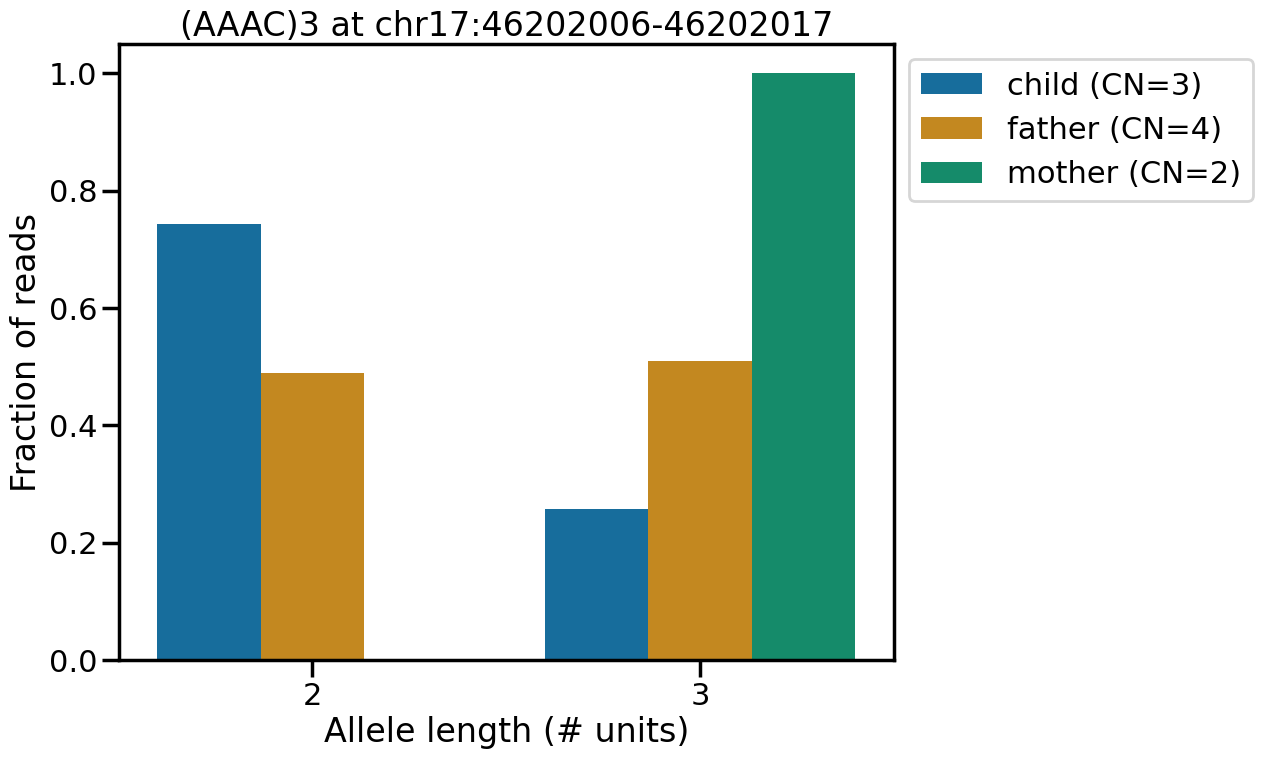

In [75]:
fig = plt.figure(figsize=(10, 8))

mapping = {"NA10846": "child (CN=3)", "NA12144": "father (CN=4)", "NA12145": "mother (CN=2)"}
ax = (
    df_plot
        .assign(sample = lambda x: [mapping[i] for i in x["sample"]])
        .groupby("sample")["allele_length"]
        .value_counts(normalize=True)
        .rename("Fraction of reads")
        .reset_index()
        .pipe(
            (sns.barplot, 'data'), 
            x="allele_length",
            y="Fraction of reads", 
            hue="sample", 
            palette="colorblind"
        )
)

ax.set(
    title="(AAAC)3 at chr17:46202006-46202017",
    xlabel="Allele length (# units)"
)
ax.get_legend().set(bbox_to_anchor=(1,1), title="")

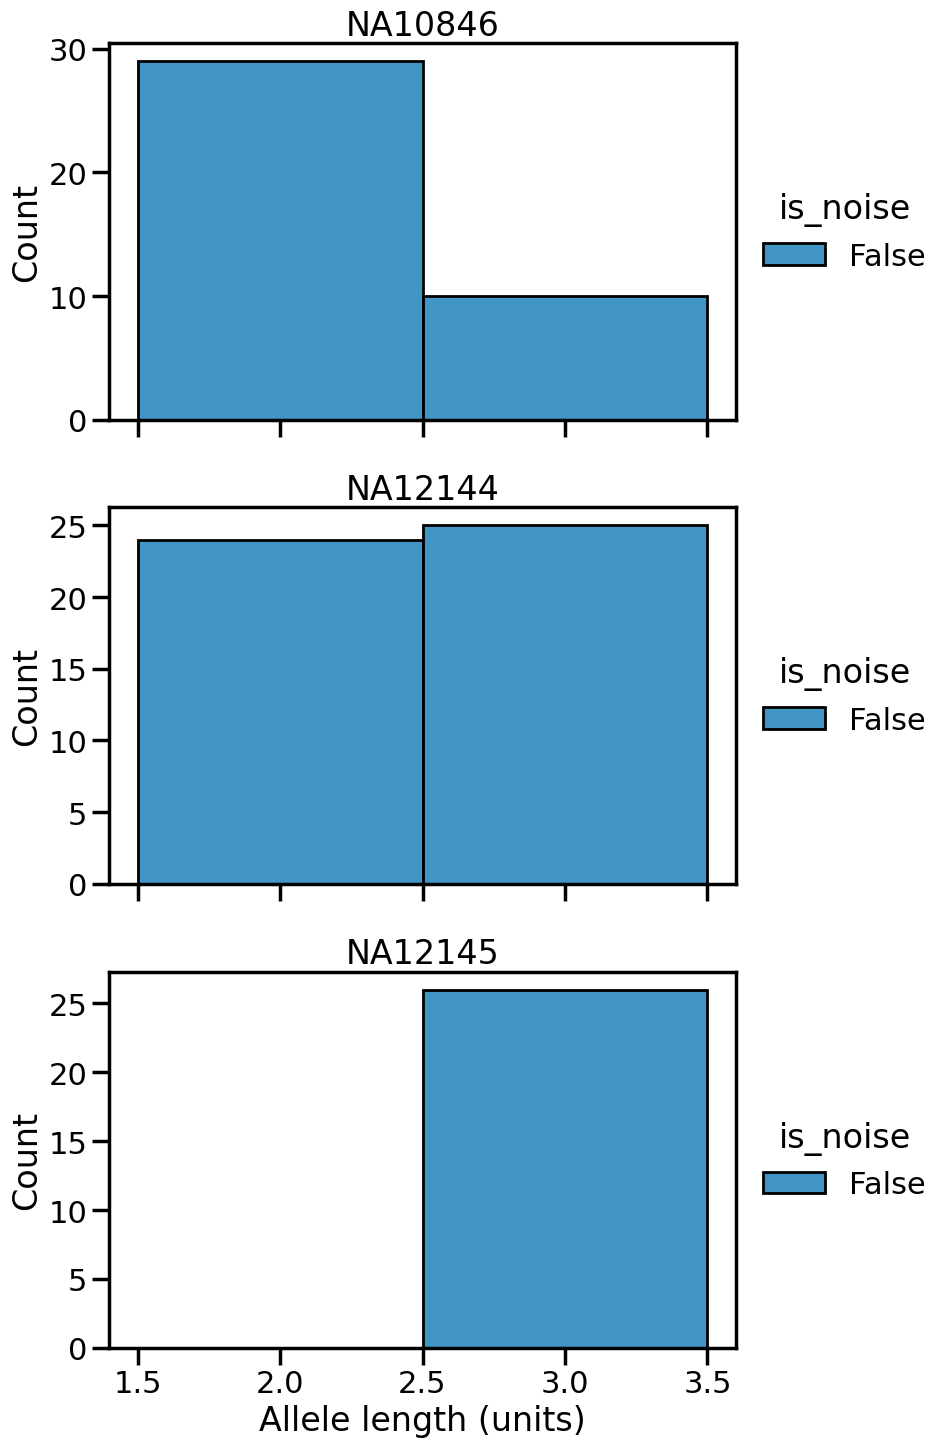

In [29]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 15), sharex=True, sharey=False)

for (name, group), ax in zip(df_plot.groupby("sample"), axes.ravel()):
    
    ax = sns.histplot(        
        group,
        ax = ax,
        multiple="stack",
        x = "allele_length",
        discrete=True, 
        hue = "is_noise",
        palette = "colorblind",
    )

    ax.set(title=name)
    ax.get_legend().set(loc="center left", bbox_to_anchor=(1.0, 0.5), frame_on=False)

ax.set(
    xlabel="Allele length (units)"
)

plt.tight_layout()